In [2]:
!pip install kaggle

In [3]:
!pip install plotly

In [4]:
from transformers import pipeline
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from io import StringIO
import re
from datetime import datetime

In [5]:
# ID file
file_id = "1-5_JXOnscS2zN1nEgNVKJX5wFL4uLb1L"
download_link = f"https://drive.google.com/uc?id={file_id}"

# dowload the file csv from Google drive
response = requests.get(download_link)
csv_data = StringIO(response.text)
df = pd.read_csv(csv_data, encoding='utf-8')

In [6]:
# data wraining
df.set_index('Unnamed: 0', inplace=True)
df.index.name ="ID"

In [7]:
df.head()

,time,comment
ID,,
0,0:03,was uppp everyone
1,0:05,this is it
2,0:07,bobchamp
3,0:07,Omg Im so excited for this
4,0:07,french here


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16130 entries, 0 to 16129
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   time     16130 non-null  object
 1   comment  16130 non-null  object
dtypes: object(2)
memory usage: 378.0+ KB


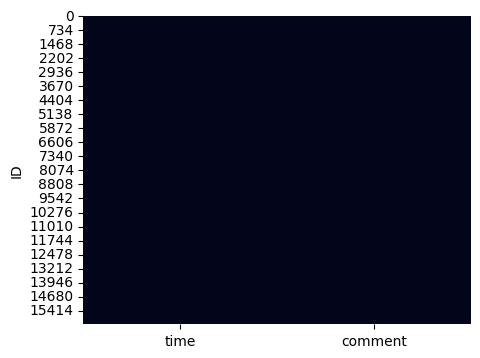

In [9]:
# there don´t present data null
plt.figure(figsize=(5, 4))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [10]:
# Load analitic model for feelings
classifier = pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [11]:
# Create function for get polarity in comments
def obtener_polaridad(comentario):
    resultado = classifier(comentario)
    return resultado[0]['label']

In [12]:
# apply the function to each comment of dataframe.
df['polarity'] = df['comment'].apply(obtener_polaridad)

In [13]:
df

,time,comment,polarity
ID,,,
0,0:03,was uppp everyone,1 star
1,0:05,this is it,5 stars
2,0:07,bobchamp,4 stars
3,0:07,Omg Im so excited for this,1 star
4,0:07,french here,3 stars
...,...,...,...
16125,2:11:41,R I P David Bowie,5 stars
16126,2:11:41,_perfect_effect_ nice to meet you,5 stars
16127,2:11:41,its finished,4 stars


In [18]:
# df de contigencia
df_origin = df.copy()

In [16]:
df.head(40)

,time,comment,polarity
ID,,,
0,0:03,was uppp everyone,1 star
1,0:05,this is it,5 stars
2,0:07,bobchamp,4 stars
3,0:07,Omg Im so excited for this,1 star
4,0:07,french here,3 stars
5,0:08,History,5 stars
6,0:09,This Is Poggers,1 star
7,0:10,it s a time a to watcha tha rovar hahaaq,5 stars
8,0:11,this will be epic,5 stars


In [20]:
df.describe(include=['object'])

,time,comment,polarity
count,16130,16130,16130
unique,6451,13149,5
top,1:33:41,I was here,5 stars
freq,16,298,8224


In [21]:
# function for create regular expression
def extraer_numeros(texto):
    numeros = re.findall(r'\d+', texto)
    return int(numeros[0]) if numeros else None
df['score'] = df['polarity'].apply(extraer_numeros)

In [22]:
def positive(puntuacion):
    return 1 if puntuacion in [4, 5] else 0
df['POSITIVE'] = df['score'].apply(positive)
df['CUMULATIVE_POSITIVE'] = df['POSITIVE'].cumsum()


def neutral(puntuacion):
    return 1 if puntuacion in [3] else 0
df['NEUTRAL'] = df['score'].apply(neutral)
df['CUMULATIVE_NEUTRAL'] = df['NEUTRAL'].cumsum()


def negative(puntuacion):
    return 1 if puntuacion in [1, 2] else 0
df['NEGATIVE'] = df['score'].apply(negative)
df['CUMULATIVE_NEGATIVE'] = df['NEGATIVE'].cumsum()

In [36]:
df.head()

,time,comment,polarity,score,POSITIVE,CUMULATIVE_POSITIVE,NEUTRAL,CUMULATIVE_NEUTRAL,NEGATIVE,CUMULATIVE_NEGATIVE
ID,,,,,,,,,,
0,0:03,was uppp everyone,1 star,1,0,0,0,0,1,1
1,0:05,this is it,5 stars,5,1,1,0,0,0,1
2,0:07,bobchamp,4 stars,4,1,2,0,0,0,1
3,0:07,Omg Im so excited for this,1 star,1,0,2,0,0,1,2
4,0:07,french here,3 stars,3,0,2,1,1,0,2


In [27]:
df1=df[['time', 'POSITIVE', 'NEUTRAL', 'NEGATIVE']]

In [30]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16130 entries, 0 to 16129
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   time      16130 non-null  object
 1   POSITIVE  16130 non-null  int64 
 2   NEUTRAL   16130 non-null  int64 
 3   NEGATIVE  16130 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 630.1+ KB


In [31]:
df['time'] = df['time'].astype(str)

# Ahora puedes realizar el groupby
grouped_df = df.groupby('time').agg({
    'POSITIVE': 'sum',
    'NEUTRAL': 'sum',
    'NEGATIVE': 'sum'
}).reset_index()

In [32]:
grouped_df

,time,POSITIVE,NEUTRAL,NEGATIVE
0,0:03,0,0,1
1,0:05,1,0,0
2,0:07,1,1,1
3,0:08,1,0,0
4,0:09,0,0,1
...,...,...,...,...
6446,9:53,2,0,1
6447,9:54,0,0,2
6448,9:57,1,0,1
6449,9:58,2,0,0


In [34]:
grouped_df['CUMULATIVE_POSITIVE'] = grouped_df['POSITIVE'].cumsum()
grouped_df['CUMULATIVE_NEUTRAL'] = grouped_df['NEUTRAL'].cumsum()
grouped_df['CUMULATIVE_NEGATIVE'] = grouped_df['NEGATIVE'].cumsum()

In [35]:
grouped_df

,time,POSITIVE,NEUTRAL,NEGATIVE,CUMULATIVE_POSITIVE,CUMULATIVE_NEUTRAL,CUMULATIVE_NEGATIVE
0,0:03,0,0,1,0,0,1
1,0:05,1,0,0,1,0,1
2,0:07,1,1,1,2,1,2
3,0:08,1,0,0,3,1,2
4,0:09,0,0,1,3,1,3
...,...,...,...,...,...,...,...
6446,9:53,2,0,1,9546,2287,4285
6447,9:54,0,0,2,9546,2287,4287
6448,9:57,1,0,1,9547,2287,4288
6449,9:58,2,0,0,9549,2287,4288


In [38]:
df_positive = grouped_df[['time', 'CUMULATIVE_POSITIVE']]
df_positive = df_positive.rename(columns={'CUMULATIVE_POSITIVE': 'y'})

In [39]:
df_neutral = grouped_df[['time', 'CUMULATIVE_NEUTRAL']]
df_neutral = df_neutral.rename(columns={'CUMULATIVE_NEUTRAL': 'y'})

In [37]:
df_negative = grouped_df[['time', 'CUMULATIVE_NEGATIVE']]
df_negative = df_negative.rename(columns={'CUMULATIVE_NEGATIVE': 'y'})

In [40]:
import pandas as pd
import plotly.express as px

# Concatenar los conjuntos de datos
df = pd.concat([df_positive, df_neutral, df_negative], keys=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

# Asignar colores a cada categoría
color_discrete_sequence = {'POSITIVE': 'green', 'NEUTRAL': 'white', 'NEGATIVE': 'red'}

# GRÁFICO ANIMADO
fig = px.scatter(df, x='time', y='y', animation_frame='time', color=df.index.get_level_values(0),
                 range_x=[0, 6], range_y=[0, 3], color_discrete_sequence=[color_discrete_sequence[key] for key in df.index.get_level_values(0)])

# Personalizar la animación
fig.update_layout(
    title='Gráfica Animada con Plotly',
    xaxis_title='time',
    yaxis_title='Eje Y',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
)

# GRÁFICO ESTÁTICO
fig_total = px.line(df, x='time', y='y', color=df.index.get_level_values(0), range_x=[0, 6], range_y=[0, 3],
                    line_dash=df.index.get_level_values(0), color_discrete_sequence=[color_discrete_sequence[key] for key in df.index.get_level_values(0)])

# Personalizar la gráfica total
fig_total.update_layout(
    title='Trayectorias del Recorrido Total',
    xaxis_title='time',
    yaxis_title='Eje Y',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
)

# Mostrar ambas gráficas
fig.show()
fig_total.show()


Output hidden; open in https://colab.research.google.com to view.

In [41]:
import pandas as pd
import plotly.express as px

# Supongamos que df_positive, df_neutral, df_negative ya están definidos...

# Asignar colores a cada categoría al crear los DataFrames
color_mapping = {'POSITIVE': 'green', 'NEUTRAL': 'white', 'NEGATIVE': 'red'}

df_positive['color'] = color_mapping['POSITIVE']
df_neutral['color'] = color_mapping['NEUTRAL']
df_negative['color'] = color_mapping['NEGATIVE']

# Concatenar los conjuntos de datos
df = pd.concat([df_positive, df_neutral, df_negative], keys=['POSITIVE', 'NEUTRAL', 'NEGATIVE'])

# GRÁFICO ANIMADO
fig = px.scatter(df, x='time', y='y', animation_frame='time', color='color',
                 range_x=[0, 6], range_y=[0, 3], color_discrete_sequence=['green', 'white', 'red'])

# Personalizar la animación
fig.update_layout(
    title='Gráfica Animada con Plotly',
    xaxis_title='time',
    yaxis_title='Eje Y',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    height=600
)

# GRÁFICO ESTÁTICO
fig_total = px.line(df, x='time', y='y', color='color', range_x=[0, 6], range_y=[0, 3],
                    line_dash='color', color_discrete_sequence=['green', 'white', 'red'])

# Personalizar la gráfica total
fig_total.update_layout(
    title='Trayectorias del Recorrido Total',
    xaxis_title='time',
    yaxis_title='Eje Y',
    template='plotly_dark',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=False),
    height=800
)

# Mostrar ambas gráficas
fig.show()
fig_total.show()


Output hidden; open in https://colab.research.google.com to view.